In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [13]:
np.set_seed(0)
# Parameters
batch_size = 32
learning_rate = 0.0001
num_epochs = 50  # Set to a higher number to give early stopping a chance to stop earlier if needed
num_classes = 2
patience = 5  # Number of epochs with no improvement after which training will be stopped

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset from folders without transformations initially
full_dataset = datasets.ImageFolder(root='./data')

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply different transforms to training, validation, and test datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained DenseNet model and modify it
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Validation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return epoch_loss, accuracy, all_preds, all_labels

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    scheduler.step()

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load best model weights
model.load_state_dict(best_model_wts)

# Test the model
test_loss, test_accuracy, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50, Train Loss: 0.6084, Val Loss: 0.5144, Val Accuracy: 0.7200
Epoch 2/50, Train Loss: 0.2632, Val Loss: 0.3874, Val Accuracy: 0.9200
Epoch 3/50, Train Loss: 0.1538, Val Loss: 0.3121, Val Accuracy: 0.8800
Epoch 4/50, Train Loss: 0.0769, Val Loss: 0.2781, Val Accuracy: 0.8800
Epoch 5/50, Train Loss: 0.0627, Val Loss: 0.2403, Val Accuracy: 0.8800
Epoch 6/50, Train Loss: 0.0400, Val Loss: 0.2031, Val Accuracy: 0.9600
Epoch 7/50, Train Loss: 0.0461, Val Loss: 0.2034, Val Accuracy: 0.9200
Epoch 8/50, Train Loss: 0.0540, Val Loss: 0.2256, Val Accuracy: 0.9200
Epoch 9/50, Train Loss: 0.0355, Val Loss: 0.2925, Val Accuracy: 0.8400
Epoch 10/50, Train Loss: 0.0343, Val Loss: 0.2201, Val Accuracy: 0.8400
Epoch 11/50, Train Loss: 0.0393, Val Loss: 0.2102, Val Accuracy: 0.8800
Early stopping at epoch 11
Test Loss: 0.3338, Test Accuracy: 0.8462


Epoch 1/50, Train Loss: 0.5814, Val Loss: 0.4378, Val Accuracy: 0.8400
Epoch 2/50, Train Loss: 0.3071, Val Loss: 0.6708, Val Accuracy: 0.6400
Epoch 3/50, Train Loss: 0.2271, Val Loss: 0.3226, Val Accuracy: 0.8800
Epoch 4/50, Train Loss: 0.1829, Val Loss: 0.1182, Val Accuracy: 0.9600
Epoch 5/50, Train Loss: 0.1002, Val Loss: 0.1309, Val Accuracy: 0.9600
Epoch 6/50, Train Loss: 0.1341, Val Loss: 0.2311, Val Accuracy: 0.9600
Epoch 7/50, Train Loss: 0.1151, Val Loss: 0.7857, Val Accuracy: 0.8400
Epoch 8/50, Train Loss: 0.0728, Val Loss: 0.3004, Val Accuracy: 0.8400
Epoch 9/50, Train Loss: 0.0803, Val Loss: 0.2339, Val Accuracy: 0.8000
Early stopping at epoch 9
Test Loss: 0.5732, Test Accuracy: 0.8077


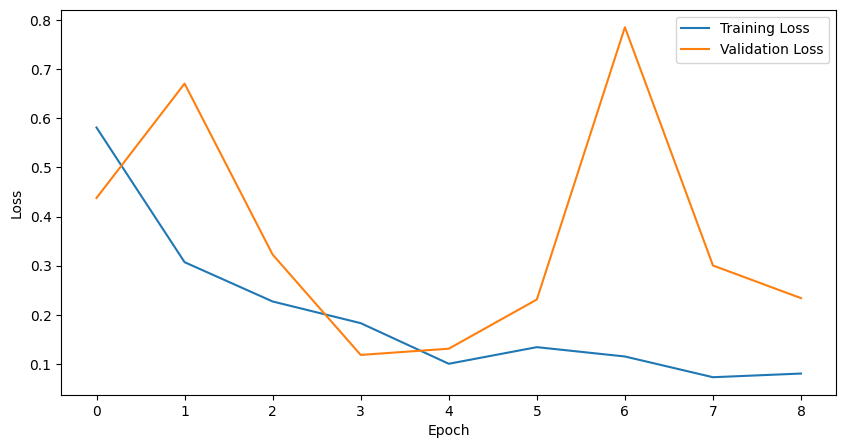

<module 'matplotlib.pyplot' from '/Users/Jai/ai_ref/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

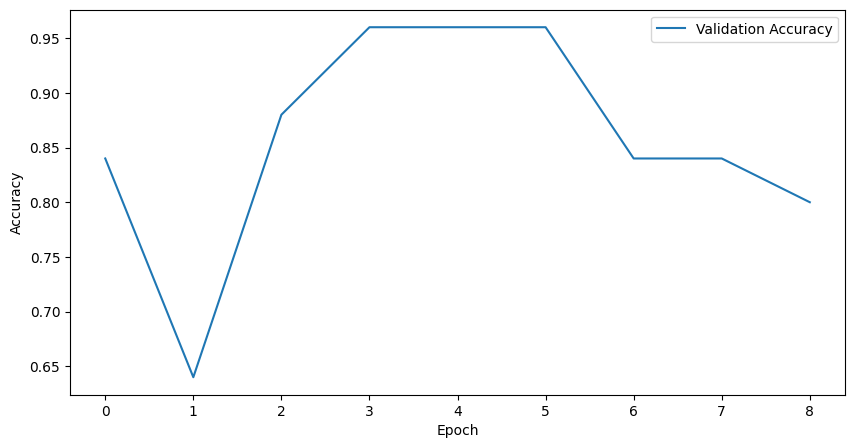

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt

np.random.seed(0)

# Parameters
batch_size = 64
initial_learning_rate = 0.001
num_epochs = 50
num_classes = 2
patience = 5

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset from folders without transformations initially
full_dataset = datasets.ImageFolder(root='./data')

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply different transforms to training, validation, and test datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained EfficientNet-B0 model and modify it
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = GradScaler()

# Training function with mixed precision
def train(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Validation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return epoch_loss, accuracy, all_preds, all_labels

# Training loop with early stopping and logging
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = model.state_dict()

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    scheduler.step(val_loss)

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_wts = model.state_dict()
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load best model weights
model.load_state_dict(best_model_wts)

# Test the model
test_loss, test_accuracy, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt


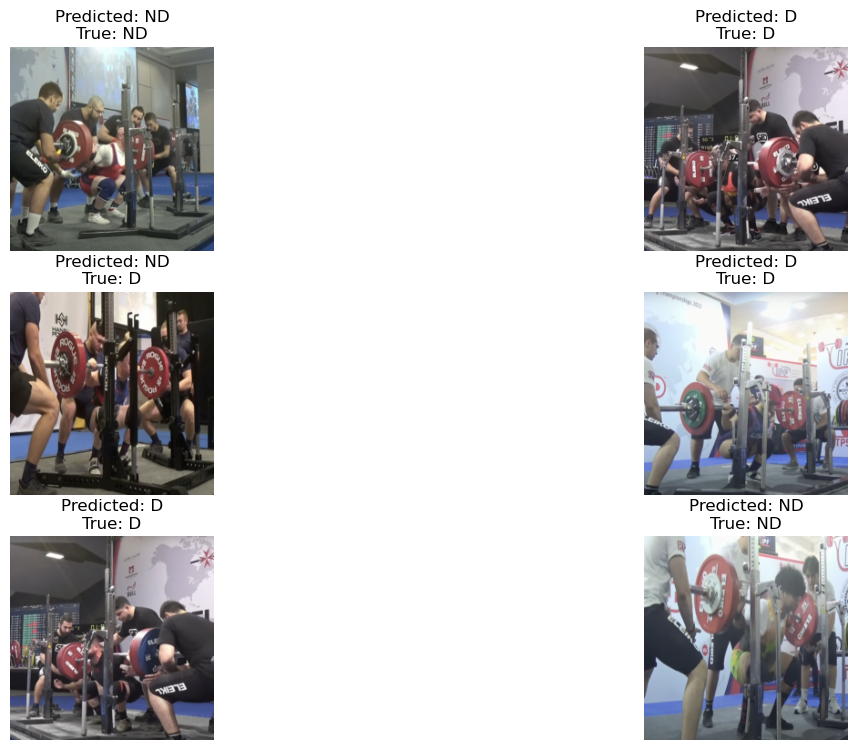

In [24]:
# Function to display a sample of test images with predictions and true labels
def show_test_predictions(model, loader, device, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 9))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

# Show a sample of test images with predictions and true labels
class_names = full_dataset.classes  # ['D', 'ND']
show_test_predictions(model, test_loader, device, class_names)
plt.show()